# Week 4: Handling Complex Images - Happy or Sad Dataset

In this assignment you will be using the happy or sad dataset, which contains 80 images of emoji-like faces, 40 happy and 40 sad.

Create a convolutional neural network that trains to 100% accuracy on these images,  which cancels training upon hitting training accuracy of >.999

In [17]:
import numpy as np
import matplotlib.pyplot as plt
import os

import tensorflow as tf
import tensorflow.keras as tfk
from tensorflow.keras import layers, optimizers, losses, models
from tensorflow.keras.preprocessing.image import load_img, ImageDataGenerator, img_to_array
from tensorflow import nn


Begin by taking a look at some images of the dataset:

In [8]:
# !wget https://github.com/doantronghieu/DEEP-LEARNING/blob/main/CSR_TF_Dev_Pro_Cert/C1/data.zip?raw=true
!unzip data.zip?raw=true.3

Archive:  data.zip?raw=true.3
   creating: data/
 extracting: data/mnist.npz          
   creating: data/W4/
   creating: data/W4/happy/
 extracting: data/W4/happy/happy1-00.png  
 extracting: data/W4/happy/happy1-01.png  
 extracting: data/W4/happy/happy1-02.png  
 extracting: data/W4/happy/happy1-03.png  
 extracting: data/W4/happy/happy1-04.png  
 extracting: data/W4/happy/happy1-05.png  
 extracting: data/W4/happy/happy1-06.png  
 extracting: data/W4/happy/happy1-07.png  
 extracting: data/W4/happy/happy1-08.png  
 extracting: data/W4/happy/happy1-09.png  
 extracting: data/W4/happy/happy1-10.png  
 extracting: data/W4/happy/happy1-11.png  
 extracting: data/W4/happy/happy1-12.png  
 extracting: data/W4/happy/happy1-13.png  
 extracting: data/W4/happy/happy1-14.png  
 extracting: data/W4/happy/happy1-15.png  
 extracting: data/W4/happy/happy1-16.png  
 extracting: data/W4/happy/happy1-17.png  
 extracting: data/W4/happy/happy1-18.png  
 extracting: data/W4/happy/happy1-19.png  
 ex

Sample happy and sad image: 


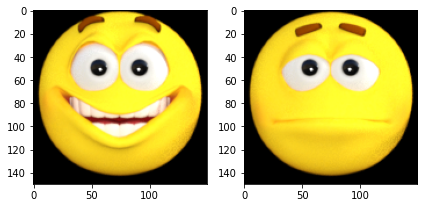

In [9]:
happy_dir = './data/W4/happy/'
sad_dir   = './data/W4/sad/'

import random
rand_idx = random.randint(0, len(happy_dir))

print('Sample happy and sad image: ')
plt.subplot(1, 2, 1)
plt.imshow(load_img(f'{os.path.join(happy_dir, os.listdir(happy_dir)[rand_idx])}'))
plt.subplot(1, 2, 2)
plt.imshow(load_img(f'{os.path.join(sad_dir, os.listdir(sad_dir)[rand_idx])}'))
plt.tight_layout()
plt.show()

It is cool to be able to see examples of the images to better understand the problem-space you are dealing with. 

However there is still some relevant information that is missing such as the resolution of the image (although matplotlib renders the images in a grid providing a good idea of these values) and the maximum pixel value (this is important for normalizing these values). For this you can use Keras as shown in the next cell:

In [10]:
print(os.path.join(happy_dir, os.listdir(happy_dir)[0]))

./data/W4/happy/happy1-12.png


In [11]:
# Load the first example of a happy face
sample_image = load_img(f'{os.path.join(happy_dir, os.listdir(happy_dir)[rand_idx])}')

# Convert the image into its numpy array representation
sample_array = img_to_array(sample_image)

print(f'           Each image has shape: {sample_array.shape}')
print(f'The maximum pixel value used is: {np.max(sample_array)}')

           Each image has shape: (150, 150, 3)
The maximum pixel value used is: 255.0


Looks like the images have a resolution of 150x150. **This is very important because this will be the input size of the first layer in your network.** 

**The last dimension refers to each one of the 3 RGB channels that are used to represent colored images.**

Since you already have coded the callback responsible for stopping training (once a desired level of accuracy is reached) in the previous two assignments this time it is already provided so you can focus on the other steps:

In [12]:
class myCallback(tfk.callbacks.Callback):
    def on_epoch_end(self, epoch, logs={}):
        if (logs.get('accuracy') is not None and logs.get('accuracy') > 0.999):
            print('\nReached 99.9% accuracy so cancelling training!')
            self.model.stop_training = True

A quick note on callbacks: 

So far you have used only the `on_epoch_end` callback but there are many more. For example you might want to check out the [EarlyStopping](https://www.tensorflow.org/api_docs/python/tf/keras/callbacks/EarlyStopping) callback, which allows you to save the best weights for your model.

Keras provides great support for preprocessing image data. A lot can be accomplished by using the `ImageDataGenerator` class. Be sure to check out the [docs](https://www.tensorflow.org/api_docs/python/tf/keras/preprocessing/image/ImageDataGenerator) if you get stuck in the next exercise. In particular you might want to pay attention to the `rescale` argument when instantiating the `ImageDataGenerator` and to the [`flow_from_directory`](https://www.tensorflow.org/api_docs/python/tf/keras/preprocessing/image/ImageDataGenerator#flow_from_directory) method.

In [15]:
def image_generator():

    # Instantiate the ImageDataGenerator class.
    train_datagen = ImageDataGenerator(rescale=1/255)

    """ Specify the method to load images from a directory and pass in the appropriate arguments:
    - directory:  should be a relative path to the directory containing the data
    - targe_size: set this equal to the resolution of each image (excluding the color dimension)
    - batch_size: number of images the generator yields when asked for a next batch. Set this to 10.
    - class_mode: How the labels are represented. Should be one of "binary", "categorical" or "sparse".
                  Pick the one that better suits here given that the labels are going to be 1D binary labels.
    """

    train_generator = train_datagen.flow_from_directory(directory='./data/W4/',
                                                        target_size=(150, 150),
                                                        batch_size=10,
                                                        class_mode='binary')
    
    return train_generator

In [16]:
# Save our generator in a variable
gen = image_generator()

Found 80 images belonging to 2 classes.


**Expected Output:**
```
Found 80 images belonging to 2 classes.
```

In [18]:
def train_happy_sad_model(train_generator):

    # Instantiate the callback
    callbacks = myCallback()

    """ Define the model, you can toy around with the architecture.
    Some helpful tips in case you are stuck:
    
    - A good first layer would be a Conv2D layer with an input shape that matches 
      that of every image in the training set (including the color dimension)

    - The model will work best with 3 convolutional layers

    - There should be a Flatten layer in between convolutional and dense layers

    - The final layer should be a Dense layer with the number of units 
      and activation function that supports binary classification. """

    model = models.Sequential([
        # First convolution
        layers.Conv2D(16, (3, 3), activation=nn.relu, input_shape=(150, 150, 3)),
        layers.MaxPooling2D(2, 2),

        # Second convolution
        layers.Conv2D(16, (3, 3), activation=nn.relu),
        layers.MaxPooling2D(2, 2),

        # Third convolution
        layers.Conv2D(16, (3, 3), activation=nn.relu),
        layers.MaxPooling2D(2, 2),

        # Flatten
        layers.Flatten(),
        # Dense layers
        layers.Dense(512, activation=nn.relu),
        layers.Dense(1, activation=nn.sigmoid)
    ])

    # Compile the model
    # Select a loss function compatible with the last layer of the network
    model.compile(loss=losses.binary_crossentropy,
                  optimizer=optimizers.RMSprop(learning_rate=0.001),
                  metrics=['accuracy'])
    
    """ Train the model
    Your model should achieve the desired accuracy in less than 15 epochs.
    You can hardcode up to 20 epochs in the function below but the callback should trigger before 15. """
    history = model.fit(train_generator, epochs=20, callbacks=[callbacks])

    return history

In [19]:
hist = train_happy_sad_model(gen)

Epoch 1/20
8/8 [==============================] - 11s 26ms/step - loss: 1.4884 - accuracy: 0.7625
Epoch 2/20
8/8 [==============================] - 0s 27ms/step - loss: 0.3144 - accuracy: 0.8875
Epoch 3/20
8/8 [==============================] - 0s 29ms/step - loss: 0.1374 - accuracy: 0.9375
Epoch 4/20
8/8 [==============================] - 0s 28ms/step - loss: 0.0915 - accuracy: 0.9500
Epoch 5/20
8/8 [==============================] - 0s 27ms/step - loss: 0.0430 - accuracy: 0.9750
Epoch 6/20
8/8 [==============================] - 0s 26ms/step - loss: 0.2439 - accuracy: 0.9250
Epoch 7/20
7/8 [=========================>....] - ETA: 0s - loss: 0.0323 - accuracy: 1.0000
Reached 99.9% accuracy so cancelling training!
8/8 [==============================] - 0s 27ms/step - loss: 0.0302 - accuracy: 1.0000


If you see the message that was defined in the callback printed out after less than 15 epochs it means your callback worked as expected and training was successful. You can also double check by running the following cell:

In [20]:
print(f"Your model reached the desired accuracy after {len(hist.epoch)} epochs")

Your model reached the desired accuracy after 7 epochs


**Congratulations on finishing the last assignment of this course!**

You have successfully implemented a CNN to assist you in the classification task for complex images. Nice job!

**Keep it up!**